**Toki Pona Modeling**

First, I'll pull in my data so that we can run same basic statistics on it.

We'll make a clone of the poki lapo repository into the file poki

```git clone https://github.com/kulupu-lapo/poki.git```

We'll also clone the old nltk-tp project

```git clone https://github.com/davidar/nltk-tp.git```

Poki lapo is currently the largest and most complete corpus of Toki Pona data

There is a structure inside the repository, but since we only care about the plaintext, we can simply toss away the headers and use the plaintext.






In [29]:
#I'm not doing this without type checking
%load_ext nb_mypy 
#you'll need to run "mypy --install-types" to get the types for installed packages

#We'll import the packages we'll use for this
import nltk
from nltk import ngrams
from collections import Counter
import numpy as np
import re
import os
import random
import warnings
import strip_markdown #to remove markdown formatting
import pickle
from tabulate import tabulate
from tqdm import tqdm

PUNCTUATION = ['!', '(', ')', '-', '[', ']', '{', '}', ';', ':', "'", '"', ',', '<', '>', '.', '/', '?', '@', '#', '$', '%', '^', '&', '*', '_', '~']
PUNCTUATIONANDTERM = ['!', '(', ')', '-', '[', ']', '{', '}', ';', ':', "'", '"', ',', '<', '>', '.', '/', '?', '@', '#', '$', '%', '^', '&', '*', '_', '~', 'EOS', 'BOS']

import matplotlib.pyplot as plt

def print_divider():
    print("\n" + "="*40 + "\n")

Version 1.0.6


In [30]:
#We'll open all files in poki directory and read them, stripping the header\
poki_plaintext_path = './poki/plaintext/'

all_files_paths = []
#all the text files in poki directory that we will read end in ".md"
for root, dirs, files in os.walk(poki_plaintext_path):
    for file in files:
        if file.endswith('.md'):
            print(os.path.join(root, file))
            all_files_paths.append(os.path.join(root, file))

print(f"Total files found: {len(all_files_paths)}")

<cell>6: error: Name "os" is not defined  [name-defined]
<cell>9: error: Name "os" is not defined  [name-defined]
<cell>10: error: Name "os" is not defined  [name-defined]


./poki/plaintext/2013/04/01-lipu-tili.md
./poki/plaintext/2013/04/02-lipu-tili.md
./poki/plaintext/2013/04/03-lipu-tili.md
./poki/plaintext/2013/10/kalama-musi-pi-jan-sewi-meli.md
./poki/plaintext/2013/10/telo-nasa.md
./poki/plaintext/2013/10/pakala.md
./poki/plaintext/2014/04/soweli-li-toki-e-soweli.md
./poki/plaintext/2014/04/toki-ijo.md
./poki/plaintext/2014/04/sina-toki-ala-toki.md
./poki/plaintext/2014/04/mi-lon.md
./poki/plaintext/2014/10/wile.md
./poki/plaintext/2014/12/mu-tu.md
./poki/plaintext/2014/12/04-lipu-tili.md
./poki/plaintext/2022/03/tenpo-open-pi-nimi-ona.md
./poki/plaintext/2022/03/ma-elopa-li-utala.md
./poki/plaintext/2022/03/lupa-ali.md
./poki/plaintext/2022/03/seme-li-mi.md
./poki/plaintext/2022/03/musi-soweli-mu.md
./poki/plaintext/2022/03/kijetesantakalu-o-nanpa-luka-luka-tu.md
./poki/plaintext/2022/03/toki-musi-pi-nasin-tu.md
./poki/plaintext/2022/03/o-kama-jo-e-nimi-iso.md
./poki/plaintext/2022/03/sona-sin-8.md
./poki/plaintext/2022/03/toki-soweli-nanpa-tu-wan

Now that we have the list of all the files, we will do some preprocessing on it.
We strip out the headers, as we don't care about the header data.
I change lines formatted like: 
```Hello there   \ ```
to ```Hello there.```.

A significant amount of the corpus is poetic, or at least not formatted like normal text, so this helps make that segment more regular.

Toki Pona doesn't really require punctuation by convention, so often text will just end in a newline. I add a '.' to all lines ending without punctuation. This will likely screw up some multi line sentences but those are not nearly as many as sentences that end on a newline. Overall, its a trade-off well worth taking.

In [31]:
def read_and_clean_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        # Remove header (header is starting with '---' and ending with '---')
        if content.startswith('---'):
            header_end = content.find('---', 3)
            if header_end != -1:
                content = content[header_end + 3:].lstrip()
        else:
            #this is just to notify us if a file has no header, but we can still process it
            warnings.warn(f"No header found in file: {file_path}")
        # Remove markdown formatting
        clean_content = strip_markdown.strip_markdown(content)
        # There are many lines that end in '[some amount of whitespace]\' instead of a '.' We will terminate these lines with a period.
        clean_content = re.sub(r'.?\s+\\\n', '.\n', clean_content)
        # We will also replace multiple newlines with a single newline
        clean_content = re.sub(r'\n+', '\n', clean_content)
        # We will terminate any line that does not end with a punctuation mark with a period.
        clean_content = re.sub(r'([^\.\!\?\n\"\,\:])\n', r'\1.\n', clean_content)
        return clean_content
    
#Now, lets see if this worked by reading one file
sample_file_path = random.choice(all_files_paths)
print(f"Reading file: {sample_file_path}")
original_content = open(sample_file_path, 'r', encoding='utf-8').read()
cleaned_content = read_and_clean_file(sample_file_path)

table = [
    ["Original Content", "Cleaned Content"],
    [original_content, cleaned_content]
]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

<cell>23: error: Name "random" is not defined  [name-defined]
<cell>33: error: Name "tabulate" is not defined  [name-defined]


Reading file: ./poki/plaintext/2020/11/tenpo-ala-la.md
╒══════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════╕
│ Original Content                                         │ Cleaned Content                                         │
╞══════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════╡
│ ---                                                      │ olin la, mi tu li jan weka ala.                         │
│ title: tenpo ala la                                      │ sina sona e nasin. mi sona kin.                         │
│ description: null                                        │ mi lape, li sitelen e awen suli.                        │
│ authors:                                                 │ sina kama jo ala e ni tan mije ante.                    │
│   - jan Asuta                                            │ mi wile toki tawa sina e pilin mi.                 

Now that our data is somewhat cleaned up from the formatting, we need to train our punkt tokenizer.
Punkt tokenizers need to be trained on a large volume of data, but it is unsupervised so I'll just use the whole dataset.

Since we've done some manual cleanup, this shouldn't be too bad.
Unfortunately, there is still a lot of data that we have that isn't very clean, but the tokenizer is capable enough to work anyway. 

One quirk of the Punkt is that it puts punctuation as its own token. This is helpful sometimes, but sometimes we don't want punctuation counting as a token.

In [32]:
#Only do this if we have not already trained and saved a tokenizer
if os.path.exists('trained_sentence_tokenizer.pkl'):
    print("Trained tokenizer already exists. Skipping training.")
else:
    tokenizer = nltk.tokenize.PunktSentenceTokenizer()
    tokenizer.train(' '.join([read_and_clean_file(fp) for fp in all_files_paths]))

    #We'll save the trained tokenizer for future use
    #Since it's not too large, we can just pickle it
    with open('trained_sentence_tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    print("Trained sentence tokenizer saved as 'trained_sentence_tokenizer.pkl'")

#Now, we can use this tokenizer to tokenize sentences in any of the files


<cell>2: error: Name "os" is not defined  [name-defined]
<cell>5: error: Name "nltk" is not defined  [name-defined]
<cell>11: error: Name "pickle" is not defined  [name-defined]


Trained tokenizer already exists. Skipping training.


In [33]:
#We'll load the trained tokenizer from the pickle file
with open('trained_sentence_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f) # type: ignore

#Let's tokenize sentences in a sample file
sample_file_path = random.choice(all_files_paths)
print(f"Tokenizing sentences in file: {sample_file_path}")
cleaned_content = read_and_clean_file(sample_file_path)
sentences = tokenizer.tokenize(cleaned_content)
print(f"Total sentences found: {len(sentences)}")
for i, sentence in enumerate(sentences[:5]):  # print first 5 sentences
    print(f"Sentence {i+1}: {sentence}")
print_divider()
print(cleaned_content[:sum(len(s) for s in sentences[:5]) + 20])  # print content of first 5 sentences

<cell>2: error: Incompatible types in assignment (expression has type "BufferedReader[_BufferedReaderStream]", variable has type "BufferedWriter")  [assignment]
<cell>6: error: Name "random" is not defined  [name-defined]
<cell>13: error: Name "print_divider" is not defined  [name-defined]


Tokenizing sentences in file: ./poki/plaintext/2023/07/sina.md
Total sentences found: 37
Sentence 1: o lon e tenpo pimej.
Sentence 2: tenpo suno ni la mi kam.
Sentence 3: moku tan pilin apej.
Sentence 4: wile ante wawa li kam.
Sentence 5: telo suli la mi tawa kal.


o lon e tenpo pimej.
tenpo suno ni la mi kam.
moku tan pilin apej.
wile ante wawa li kam.
telo suli la mi tawa kal.
taso lon ma kin


In [34]:
#Now that we have a trained tokenizer, we can use it to tokenize all files. I'll generate 1-4gram frequency distributions across all files.
all_sentences = []
print("Tokenizing all files...")
for file_path in tqdm(all_files_paths):
    cleaned_content = read_and_clean_file(file_path)
    sentences = tokenizer.tokenize(cleaned_content)
    all_sentences.extend(sentences)

print (f"Total sentences tokenized from all files: {len(all_sentences)}")
print("Examples of tokenized sentences:")
for sentence in all_sentences[:5]:
    print(" - " + sentence)


Error in type checker, you can turn it off with '%nb_mypy Off'


Tokenizing all files...


100%|██████████| 1529/1529 [00:05<00:00, 262.89it/s]

Total sentences tokenized from all files: 97772
Examples of tokenized sentences:
 - lon li ike tawa jan mute.
 - kulupu lawa li lukin e lon pi jan ali li lawa kepeken wawa ali.
 - jan mute li pali mute tan mani lili.
 - taso jan lawa li pali lili li kama mani tan jan mute.
 - ona lawa li jo e kulupu lawa e nasin sewi e mani mute.


In [35]:
#Tokenize all sentences into words, then generate n-grams

# Tokenize sentences into words
all_tokens = []
print("Tokenizing...")
for sentence in tqdm(all_sentences):
    words = nltk.word_tokenize(sentence)
    # Add BOS and EOS tokens
    words = ['BOS'] + words + ['EOS']
    all_tokens.extend(words)
all_words = [w for w in all_tokens if w not in PUNCTUATIONANDTERM]

print("Token sample:")
print(all_tokens[230:250])
print("Words sample:")
print(all_words[230:250])


print(f"Total words: {len(all_tokens)}")
print(f"Unique words: {len(set(all_tokens))}")
print()

print("Generating n-grams and counting frequencies...")

# Generate n-grams (1-4) and count frequencies
n_token_freqs = {}  # Store frequency distributions for each n
n_word_freqs = {}
for n in tqdm(range(1, 5)):
    n_grams = list(ngrams(all_tokens, n))
    n_token_freqs[n] = Counter(n_grams)
    n_grams = list(ngrams(all_words, n))
    n_word_freqs[n] = Counter(n_grams)

# Print results for each n
for n in range(1, 5):
    print(f"=== {n}-grams (top 5 out of {len(n_token_freqs[n])} tokens) ===")
    for gram, count in n_token_freqs[n].most_common(5):
        gram_str = ' '.join(gram) if isinstance(gram, tuple) else gram
        print(f"  {count:5d}x  {gram_str}")
    print(f"=== {n}-grams (top 5 out of {len(n_word_freqs[n])} words) ===")
    for gram, count in n_word_freqs[n].most_common(5):
        gram_str = ' '.join(gram) if isinstance(gram, tuple) else gram
        print(f"  {count:5d}x  {gram_str}")

<cell>6: error: Name "tqdm" is not defined  [name-defined]
<cell>6: error: Name "all_sentences" is not defined  [name-defined]
<cell>7: error: Name "nltk" is not defined  [name-defined]
<cell>11: error: Name "PUNCTUATIONANDTERM" is not defined  [name-defined]
<cell>28: error: Name "tqdm" is not defined  [name-defined]
<cell>29: error: Name "ngrams" is not defined  [name-defined]
<cell>30: error: Name "Counter" is not defined  [name-defined]
<cell>31: error: Name "ngrams" is not defined  [name-defined]
<cell>32: error: Name "Counter" is not defined  [name-defined]


Tokenizing...


100%|██████████| 97772/97772 [00:03<00:00, 25160.58it/s]


Token sample:
['li', 'pilin', 'wawa', 'ala', 'li', 'wile', 'moli', '.', 'EOS', 'BOS', 'taso', 'ona', 'li', 'moli', 'ala', 'tan', 'jan', 'Tili', '.', 'EOS']
Words sample:
['jan', 'Loki', 'tenpo', 'la', 'jan', 'Loki', 'li', 'kama', 'jo', 'e', 'sike', 'suno', 'mute', 'li', 'jo', 'e', 'wawa', 'lili', 'li', 'pana']
Total words: 1264229
Unique words: 10860

Generating n-grams and counting frequencies...


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

=== 1-grams (top 5 out of 10860 tokens) ===
  97772x  BOS
  97772x  EOS
  84784x  .
  82309x  li
  48631x  e
=== 1-grams (top 5 out of 10832 words) ===
  82309x  li
  48631x  e
  33798x  jan
  32942x  mi
  31982x  ni
=== 2-grams (top 5 out of 54637 tokens) ===
  97771x  EOS BOS
  82845x  . EOS
  16028x  ona li
  12550x  la ,
  10902x  BOS jan
=== 2-grams (top 5 out of 59409 words) ===
  16305x  ona li
   9068x  ni li
   7921x  e ni
   7234x  li lon
   7148x  li kama
=== 3-grams (top 5 out of 216252 tokens) ===
  82844x  . EOS BOS
  10902x  EOS BOS jan
  10039x  EOS BOS mi
   7193x  ! EOS BOS
   7074x  EOS BOS ona
=== 3-grams (top 5 out of 254076 words) ===
   3904x  la ona li
   3187x  toki e ni
   3128x  li toki e
   2055x  li pana e
   1761x  li jo e
=== 4-grams (top 5 out of 457542 tokens) ===
   8986x  . EOS BOS jan
   8404x  . EOS BOS mi
   6308x  EOS BOS ona li
   6291x  . EOS BOS ona
   4649x  . EOS BOS taso
=== 4-grams (top 5 out of 531169 words) ===
   2352x  li toki e ni
   1

In [36]:

# Define a plotting function for unigram frequency charts
def plot_unigrams(words_dict, title, color, top_n=140, figsize=(14, 6), annotate="counts"):
    """
    Plot top n unigrams from a words frequency dictionary.
    
    Args:
        words_dict: Dictionary mapping words to frequency counts
        title: Title for the plot
        color: matplotlib color specification
        top_n: Number of top unigrams to display (default: 140)
        figsize: Figure size as (width, height) tuple (default: (14, 6))
    """
    common = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    labels = [w for w, _ in common]
    counts = [c for _, c in common]
    
    plt.figure(figsize=figsize)
    plt.bar(range(len(labels)), counts, color=color, width=0.8)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=7)
    plt.title(title)
    plt.xlabel("Unigram")
    plt.ylabel("Frequency")
    
    # Annotate bars with counts
    for i, c in enumerate(counts):
        if annotate == "counts":
            plt.text(i, c, str(c), rotation=45, va='bottom', fontsize=16)
        elif annotate == "percent":
            percent = c / sum(counts) * 100
            plt.text(i, c, f"{percent:.1f}%", rotation=45, va='bottom', fontsize=16)
        elif annotate == "log":
            log_value = np.log10(c) if c > 0 else 0
            plt.text(i, c, f"{log_value:.2f}", rotation=45, va='bottom', fontsize=16)
        else:
            pass  # No annotation
        
    
    plt.tight_layout()
    plt.show()
    
    return common, labels, counts


In [37]:
# Prepare Toki Pona data for plotting
unigrams = n_word_freqs.get(1)  # We use n_word_freqs because we don't want '.' as the most common token.
if unigrams is None:
    raise RuntimeError("n_word_freqs[1] not found")

# Convert Counter to dictionary for consistent format
toki_pona_words_dict = dict(unigrams)

print(f"Prepared {len(toki_pona_words_dict)} Toki Pona unigrams for plotting")


Prepared 10832 Toki Pona unigrams for plotting


Now that we have the counts, we can compare against the counts from the nltk-tp project by David A Roberts (davidar) and against an English word counts. I've acquired a list for English word counts from [wordfrequency.info](https://www.wordfrequency.info/samples.asp)

In [38]:
# Load nltk-tp 1-gram frequencies
NLTK_1GRAM_FILE_PATH = "./nltk-tp/words.txt"

# Parse the file into standard format
nltk_words_dict = {}
with open(NLTK_1GRAM_FILE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line[0] == '#' or not line:
            continue
        parts = line.split()
        if len(parts) >= 2:
            count = int(parts[0])
            word = parts[1]
            nltk_words_dict[word] = count

print(f"Loaded {len(nltk_words_dict)} nltk-tp words")


<cell>6: error: Incompatible types in assignment (expression has type "TextIOWrapper[_WrappedBuffer]", variable has type "BufferedWriter")  [assignment]


Loaded 131 nltk-tp words


In [39]:
# Load English 1-gram frequencies
import csv

ENGLISH_1GRAM_FILE_PATH = "./data/wordFrequency.csv"

# Parse the CSV file into standard format
# CSV format: rank, lemma, PoS, freq, ...
english_words_dict = {}
with open(ENGLISH_1GRAM_FILE_PATH, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0:  # skip header
            continue
        if len(row) >= 4:
            try:
                word = row[1]  # lemma is column 1
                count = int(row[3])  # freq is column 3
                english_words_dict[word] = count
            except (ValueError, IndexError):
                continue

print(f"Loaded {len(english_words_dict)} English words")


Error in type checker, you can turn it off with '%nb_mypy Off'


Loaded 4380 English words


<cell>15: error: Name "english_words_dict" is not defined  [name-defined]



Generating comparison plots...



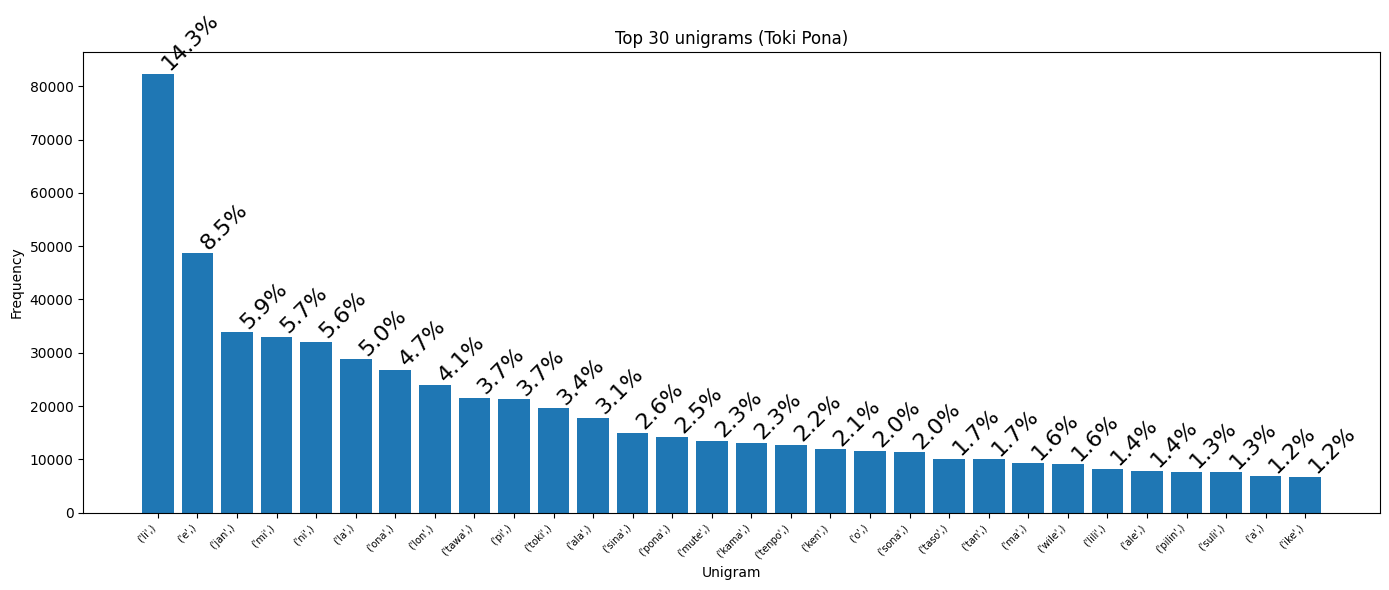

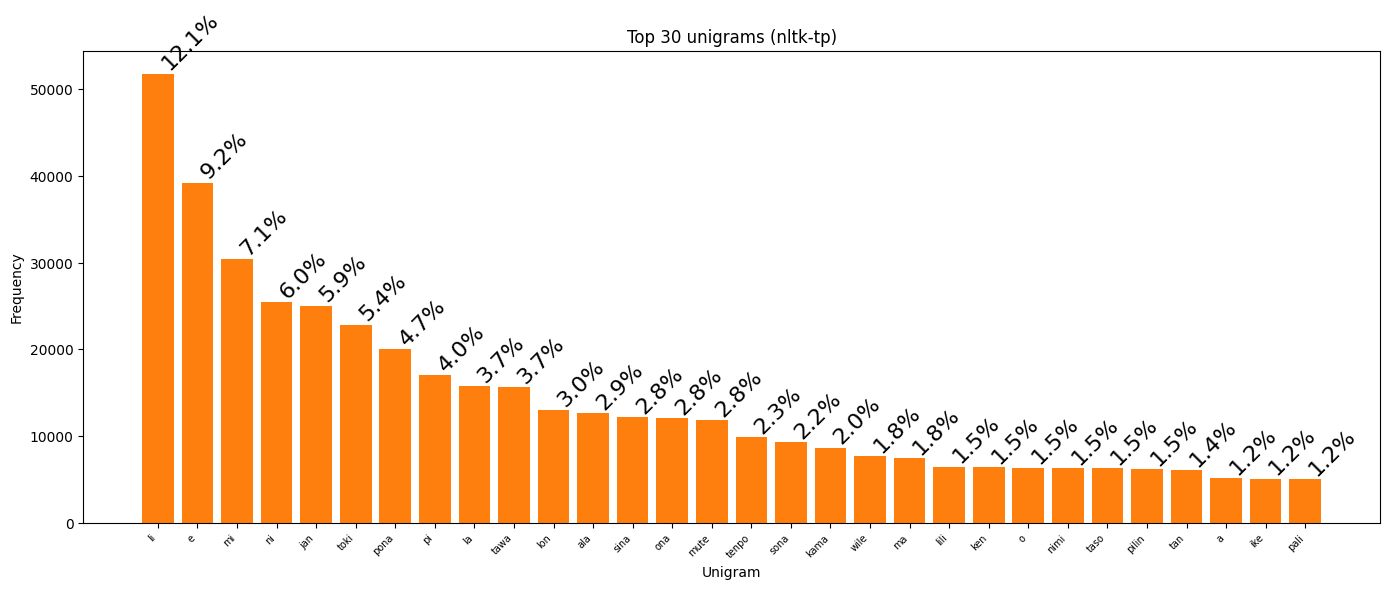

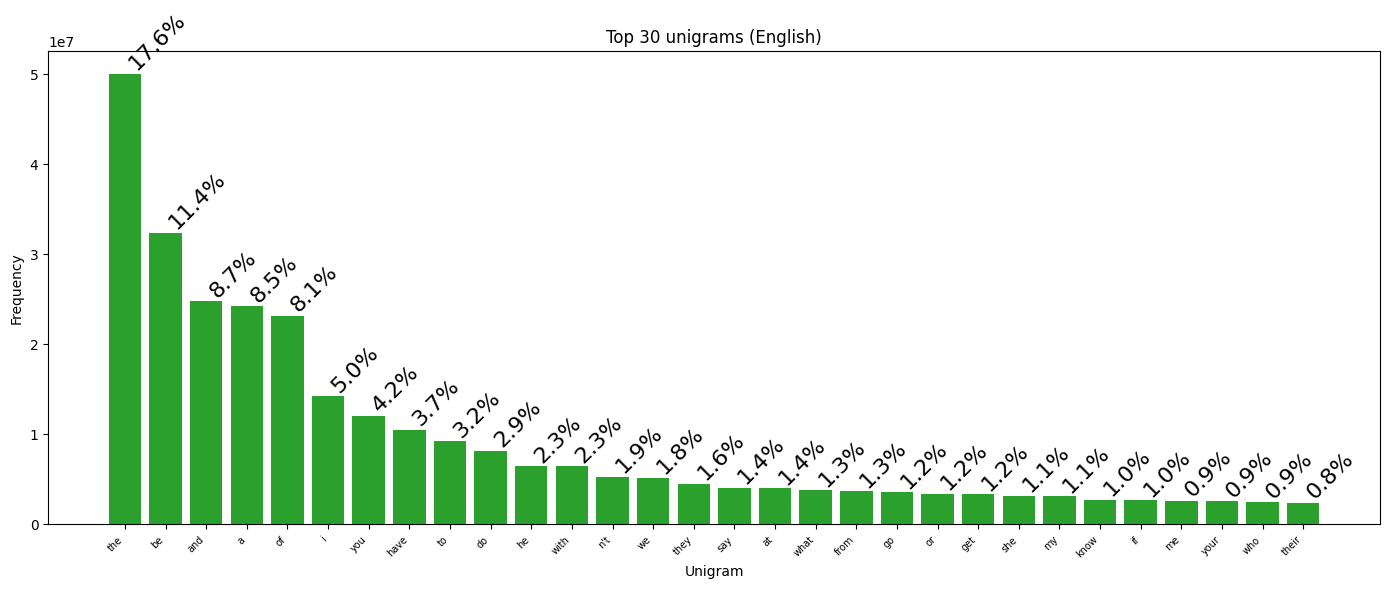


Comparison plots generated!


In [40]:
# Plot all three frequency charts for comparison
print("\nGenerating comparison plots...\n")

top_n = 30

annotation_type = "percent" # can be "counts", "percent", "log", or None

# Plot Toki Pona
plot_unigrams(toki_pona_words_dict, f"Top {top_n} unigrams (Toki Pona)", "C0", top_n=top_n, figsize=(14, 6), annotate=annotation_type)

# Plot nltk-tp
plot_unigrams(nltk_words_dict, f"Top {top_n} unigrams (nltk-tp)", "C1", top_n=top_n, figsize=(14, 6), annotate=annotation_type)

# Plot English
plot_unigrams(english_words_dict, f"Top {top_n} unigrams (English)", "C2", top_n=top_n, figsize=(14, 6), annotate="percent")

print("\nComparison plots generated!")


These plots look pretty similar, which isn't terribly surprising. Noticeably though, as the index goes up the counts for English seem to fall much faster. The most popular entry for English, 'the', has  50033612 / 2417058 = 20.7 times as many occurrences as the 30th entry, 'their'. In comparison, the most popular entry in Toki Pona, 'li' has 82309 / 6717 = 12.3 times as many occurrences as the 30th entry, 'ike'. 

We can visualize this better with a log log graph of our words. I normalize for the total number of entries so that it is easier to compare the datasets.

Error in type checker, you can turn it off with '%nb_mypy Off'


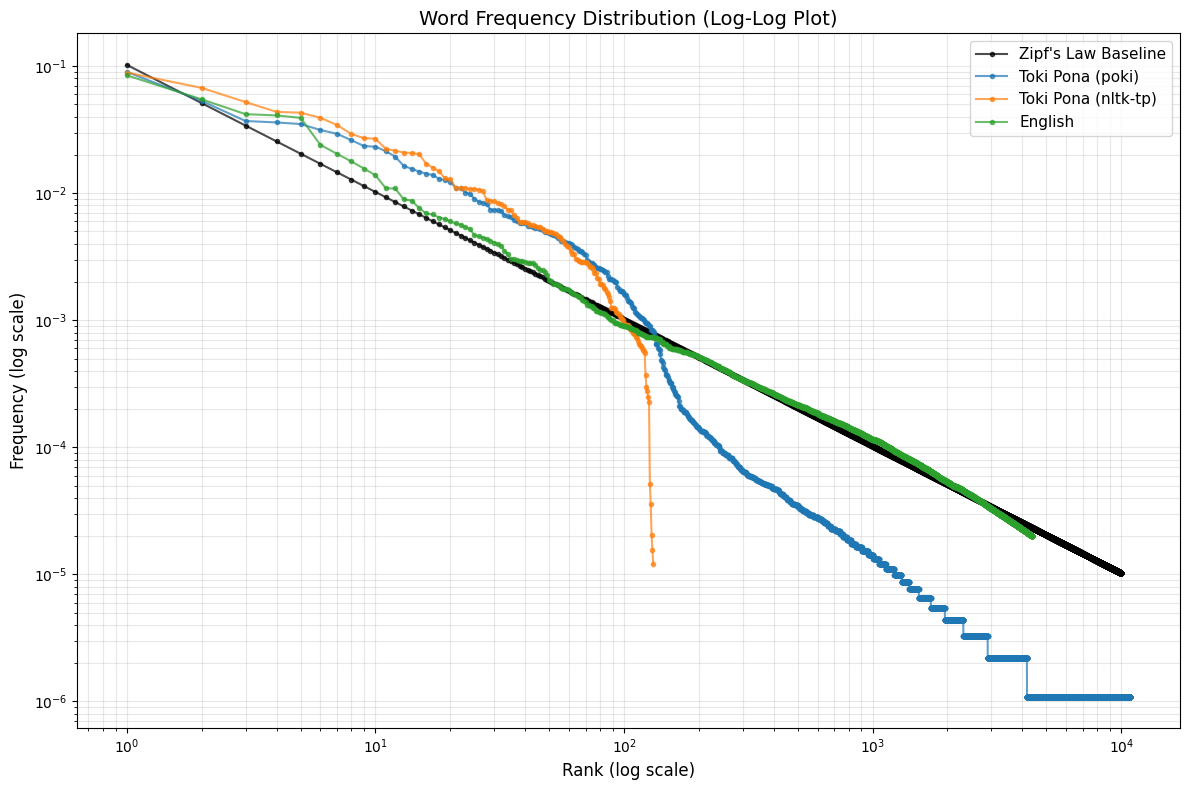

In [ ]:
# Create a log-log plot comparing all three distributions
fig, ax = plt.subplots(figsize=(12, 8))

normalize = True

zipf_baseline_distribution = {} # Create a Zipf's law baseline distribution
for rank in range(1, 10001):
    zipf_baseline_distribution[rank] = 10000 / rank #Use a large constant to make the line visible

# Prepare data for each distribution
distributions = [
    (zipf_baseline_distribution, "Zipf's Law Baseline", "Black"),
    (toki_pona_words_dict, "Toki Pona (poki)", "C0"),
    (nltk_words_dict, "Toki Pona (nltk-tp)", "C1"),
    (english_words_dict, "English", "C2")
]

for words_dict, label, color in distributions:
    # Sort by frequency (descending) and get frequencies
    sorted_items = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)
    sum_counts = sum(words_dict.values()) if normalize else 1# get total count for normalization. Set this to 1 to disable normalization.
    frequencies = [count / sum_counts for _, count in sorted_items]

    # Create ranks (1-indexed)
    ranks = np.arange(1, len(frequencies) + 1)
    
    # Plot on log-log scale
    ax.loglog(ranks, frequencies, marker='o', markersize=3, linestyle='-', 
              linewidth=1.5, label=label, color=color, alpha=0.7)

ax.set_xlabel("Rank (log scale)", fontsize=12)
ax.set_ylabel("Frequency (log scale)", fontsize=12)
ax.set_title("Word Frequency Distribution (Log-Log Plot)", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, which="both", ls="-", alpha=0.3)

plt.tight_layout()
plt.show()

We can see that the English graph is much smoother, as it has many more entries. If we show the graph without normalization (uncomment the relevant line), we will see the line for  English is much higher up and has many more dots. We can also see a limitation of the nltk-tp dataset, as the line dives very aggressively as there are both not enough words or occurrences of them to chart. On the other hand, the larger (if less clean) poki dataset is chart out all the way to ranks more than 10^4. The english word frequencies only go up to 5000 words so it gets abruptly cut off, but the general trend is obvious. 

The nltk-tp and poki dataset share the same shape until around the 120th word.

Now that we have taken a look at the corpuses, we can start processing them. 
First, lets make some basic n gram models.
One thing that is missing currently from out data is the Beginning of Sequence(BOS) and End of Sequence(EOS) tokens. Since I only want to generate one sentence at a time, I want to segment the sentences first then add these tokens. Since I'll be using tokens, this means I'll also hopefully generate appropriate punctuation.

In [42]:
# Build NLTK n-gram models (1-4 grams) using the generated n-gram frequencies
from collections import defaultdict
import random

# Build conditional frequency distributions for n-grams (1-4)
n_cfds = {}  # Store CFD for each n

for n in range(1, 5):
    n_grams = n_token_freqs[n]  # Use token-based n-grams (includes punctuation/BOS/EOS)
    cfd = defaultdict(lambda: defaultdict(int))
    
    if n == 1:
        # For unigrams, just store frequencies
        for (word,), count in n_grams.items():
            cfd[None][word] += count
    else:
        # For n-grams > 1, store conditional probabilities
        # Context is all but the last token, prediction is the last token
        for gram, count in n_grams.items():
            #if any token in the gram is 'BOS', replace all tokens before it with 'BOS' to pad the context
            for i in range(len(gram)):
                if gram[i] == 'BOS':
                    gram = tuple(['BOS'] * i + list(gram[i:]))
                    break
            context = gram[:-1]
            prediction = gram[-1]  # The last token
            cfd[context][prediction] += count
    
    n_cfds[n] = cfd

# Function to generate a sentence using any n-gram model
def generate_sentence(n=2, start_token='BOS', max_len=20):
    """
    Generate a sentence using an n-gram model.
    
    Args:
        n: The n-gram size (1-4)
        start_token: Starting token (default: 'BOS')
        max_len: Maximum sentence length (default: 20)
    
    Returns:
        Generated sentence as a string
    """
    if n not in n_cfds:
        raise ValueError(f"Model not available for n={n}. Available: {list(n_cfds.keys())}")
    
    cfd = n_cfds[n]
    
    if n == 1:
        # For unigrams, generate random words based on frequency
        sentence = [start_token]
        for _ in range(max_len):
            next_words = cfd[None]
            if not next_words:
                break
            total = sum(next_words.values())
            r = random.randint(1, total)
            cumulative = 0
            for word, freq in next_words.items():
                cumulative += freq
                if r <= cumulative:
                    sentence.append(word)
                    break
            if sentence[-1] == 'EOS':
                break
    else:
        # For n-grams > 1, generate using context
        sentence = [start_token]
        
        for _ in range(max_len):
            # Get the last (n-1) tokens as context
            context = tuple(sentence[-(n-1):]) if len(sentence) >= n-1 else tuple([start_token] * (n-1-len(sentence)) + sentence)
            next_words = cfd[context]
            
            if not next_words:
                break

            total = sum(next_words.values())
            r = random.randint(1, total)
            cumulative = 0
            for word, freq in next_words.items():
                cumulative += freq
                if r <= cumulative:
                    sentence.append(word)
                    break
            
            if sentence[-1] == 'EOS':
                break
    
    # Clean up: remove BOS/EOS and None values
    cleaned = [w for w in sentence if w not in ['BOS', 'EOS', None]]
    return ' '.join(cleaned)

# Example usage: Generate sentences using different n-gram models
print("Generated sentences by n-gram model:\n")
for n in range(1, 5):
    print(f"=== {n}-gram model ===")
    for i in range(6):
        result = generate_sentence(n=n)
        if result:
            print(f"  {i+1}: {result}")
        else:
            print(f"  {i+1}: [empty]")
    print()


Error in type checker, you can turn it off with '%nb_mypy Off'


Generated sentences by n-gram model:

=== 1-gram model ===
  1: [empty]
  2: ma lon ) li
  3: jan sona insa tawa lon
  4: tan sinpin lili la Lojema e mute o a . ale : 86 lili ! li e
  5: a pini : .
  6: e jan ! ante musi tan sinpin . li e . sona li ona ala . ken ken

=== 2-gram model ===
  1: mani sin la , nasin sina taso sina wile e nasin jan , jan wan .
  2: in sitelen ni li telo Sansan .
  3: mi .
  4: ona tu o kepeken ilo tenpo lon ma ni taso li pali e lawa ona li weka e ni la
  5: palisa jelo li toki Akatu la selo ona li toki tawa pimeja li lon ni mi ni li kama
  6: jan misikeke pi kama sona ala e pipi li ken kepeken ilo waso .

=== 3-gram model ===
  1: li wile ala e tenpo ni .
  2: sina weka ala tan ilo ( konversacia libro ) .
  3: 18 mi moku e kasi .
  4: ona li toki ike ona tawa jan ante ale li moku e nasa pi soweli len li musi
  5: ma ni li ale .
  6: lipamanka o. mi o kalama e kalama lili : ona ( o ) -ken e ta-wa mi , la

=== 4-gram model ===
  1: kiwen suli tu , li pana e s